# Setup

In [14]:
from dotenv import load_dotenv
load_dotenv()

True

## LLM and Embedding

In [2]:
import os
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings

# TODO: Add Ollama alternative

############### Init LLM ###############
llm = AzureChatOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
    openai_api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
)

############### Init embeddings ###############
embeddings = AzureOpenAIEmbeddings(model=os.getenv("AZURE_OPENAI_EMB_DEPLOYMENT_NAME"))

# Persistent database

In [3]:
import sqlite3
chat_db_path = "db/chats/example.db"
student_db_path = "db/students/students.db"

conn = sqlite3.connect(chat_db_path, check_same_thread=False)

In [4]:
from langgraph.checkpoint.sqlite import SqliteSaver
persistent_memory = SqliteSaver(conn)

## State

In [5]:
from typing import Optional, List
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState

# Student class
class Student(BaseModel):
    ''' Class for agent to fill out, which fits with SQL table '''
    
    username: str = Field(description='The username for the student, which is a unique identifier')
    name: Optional[str] = Field(None, description='Name of student')
    summary: Optional[str] = Field(None, description='A summary of the students profile, based on available fields')
    @property
    def persona(self) -> str:
        return f"Username:\n {self.username}\n Name:\n {self.name}\nSummary\n {self.summary}"

# Graph state
class StudyAgentState(MessagesState):
    username: str
    student: Optional[Student]
    max_messages: int
    session_docs: List[str]
    documents: List[str]

# Teacher

In [6]:
from langchain_core.messages import SystemMessage, HumanMessage

teacher_instructions = """
    You are an experienced and patient teacher helping students learn 
    by answering their questions. Your goal is to not only provide 
    the correct answers but also to explain concepts clearly and thoroughly, 
    breaking them down into smaller steps when necessary. Provide 
    examples where appropriate, encourage critical thinking by asking 
    follow-up questions, and make sure the student feels supported in 
    their learning journey. Aim to foster a deeper understanding 
    rather than just memorization. If the student seems confused, 
    gently guide them through the problem with hints or re-explanations.

    You should take the following documents into consideration
    and cite them if used:
    {documents}
    """

def answering_teacher(state: StudyAgentState):
    ''' Teacher node to answer student '''
    print('--- Teacher ---')
    messages = state['messages'] # Contains student question
    documents = state['documents']
    sys_msg = teacher_instructions.format(documents=documents)
    answer = llm.invoke([SystemMessage(content=sys_msg)] + messages) # Answers student question

    return {'messages': answer} # Adds answer to messages

# Vector DB

## Upserting

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_openai import AzureOpenAIEmbeddings
from langchain_chroma import Chroma

# Define the directory containing the text file and the persistent directory
current_dir = os.path.dirname(os.path.abspath("study_agent_langgraph.ipynb"))
db_dir = os.path.join(current_dir, "db")
persistent_directory = os.path.join(db_dir, "test_material")

# Function to create and persist vector store
def create_vector_store(docs, embeddings, store_name):
    persistent_directory = os.path.join(db_dir, store_name)
    if not os.path.exists(persistent_directory):
        print(f"\n--- Creating vector store {store_name} ---")
        Chroma.from_documents(
            docs, embeddings, persist_directory=persistent_directory)
        print(f"--- Finished creating vector store {store_name} ---")
    else:
        print(
            f"Vector store {store_name} already exists. No need to initialize.")

file_dir = os.path.join('./', "data", 'test_data')

# Check if the Chroma vector store already exists
if not os.path.exists(persistent_directory):
    print("Persistent directory does not exist. Initializing vector store...")

    # Ensure the books directory exists
    if not os.path.exists(file_dir):
        raise FileNotFoundError(
            f"The directory {file_dir} does not exist. Please check the path."
        )

    # List all text files in the directory
    pdf_files = [f for f in os.listdir(file_dir) if f.endswith(".pdf")]

    # Read the text content from each file and store it with metadata
    documents = []
    for pdf_file in pdf_files:
        file_path = os.path.join(file_dir, pdf_file)
        loader = PyPDFLoader(file_path)
        pdf_docs = loader.load()
        for doc in pdf_docs:
            # Add metadata to each document indicating its source
            doc.metadata = {"source": pdf_file}
            documents.append(doc)

    # Split the documents into chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
    docs = text_splitter.split_documents(documents)

    # Display information about the split documents
    print("\n--- Document Chunks Information ---")
    print(f"Number of document chunks: {len(docs)}")

    # Create embeddings
    print("\n--- Creating embeddings ---")
    embeddings = AzureOpenAIEmbeddings(model=os.getenv("AZURE_OPENAI_EMB_DEPLOYMENT_NAME"))
    print("\n--- Finished creating embeddings ---")

    # Create the vector store and persist it
    print("\n--- Creating and persisting vector store ---")
    db = Chroma.from_documents(
        docs, embeddings, persist_directory=persistent_directory)
    print("\n--- Finished creating and persisting vector store ---")

else:
    print("Vector store already exists. No need to initialize.")


Vector store already exists. No need to initialize.


## Retrievers

In [8]:
from langchain_chroma import Chroma
from langchain.vectorstores import DocArrayInMemorySearch

def retrieve_docs_chroma(state: StudyAgentState):
    ''' Retriever for getting context and docs '''
    print('--- Chroma Retriever ---')
    query = state["messages"][-1].content
    
    embeddings = AzureOpenAIEmbeddings(model=os.getenv("AZURE_OPENAI_EMB_DEPLOYMENT_NAME"))
    current_dir = os.path.dirname(os.path.abspath("development.ipynb"))
    db_dir = os.path.join(current_dir, "db")
    persistent_directory = os.path.join(db_dir, "test_material")
    db = Chroma(
        persist_directory=persistent_directory,
        embedding_function=embeddings
    )
    retriever = db.as_retriever()
    docs = retriever.invoke(query)

    return {'documents': docs}

def retrieve_docs_inmemory(state: StudyAgentState):
    ''' Retriever for getting context and docs '''
    print('--- InMemory Retriever ---')
    query = state["messages"][-1].content
    documents = state["session_docs"]
    embeddings = AzureOpenAIEmbeddings(model=os.getenv("AZURE_OPENAI_EMB_DEPLOYMENT_NAME"))
    retriever = DocArrayInMemorySearch.from_documents(documents, embeddings)

    docs = retriever.similarity_search(query, k=3)

    return {'documents': docs}

# Document Grader

In [9]:
# First is the retrieval grader, which takes a documents content and evaluates whether it is useful or not
# The grader is a simple chain, with a prompt and an llm
# It is later used in a node, to go through retrieved documents
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

# Structured output class - Either useful or useless
class DocumentGrade(BaseModel):
    document_grade: str = Field(description="Grading of retrieved document, 'useful' or 'useless'")

# Prompt template for the llm to evaluate documents
grader_instruction = """
You are tasked with determining whether a document is relevant to a student's inquiry.
Evaluate the document based on its ability to directly address or provide useful information regarding the question or topic posed by the student.
If the document is relevant and contains valuable information, respond with 'useful'.
If the document is unrelated or does not contribute meaningfully to the inquiry, respond with 'useless'.
Be objective and concise in your evaluation.
"""
grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", grader_instruction),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# LLM with class as output, string of either useful or useless
grader_llm = llm.with_structured_output(DocumentGrade)

# Grader chain
doc_grader = grader_prompt | grader_llm

In [10]:
def grade_docs(state: StudyAgentState):
    ''' Grader to filter retrieved documents by relevance '''
    print('--- Doc Grader ---')
    question = state['messages'][-1].content
    documents = state['documents']
    filtered_docs = []
    
    for doc in documents:
        usefulness = doc_grader.invoke({'document': doc, 'question': question})
        if usefulness.document_grade == 'useful':
            filtered_docs.append(doc)
        elif usefulness.document_grade == 'useless':
            continue

    return {'documents': filtered_docs}

# Edges

In [11]:
def retriever_route(state: StudyAgentState):
    ''' Deciding which retriever to use based on session documents '''

    session_docs = state.get('session_docs', [])

    if len(session_docs) == 0:
        return 'chroma_retriever'
    else:
        return 'inmemory_retriever'

In [12]:
def got_docs(state: StudyAgentState):
    ''' Check if there are relevant documents for the teachers answer '''
    # TODO: Add a max_turns to state and/or a web search or other deafult

    relevant_docs = state.get('documents', [])

    if len(relevant_docs) == 0:
        return 'chroma_retriever'
    else:
        return 'teacher'

# Graph

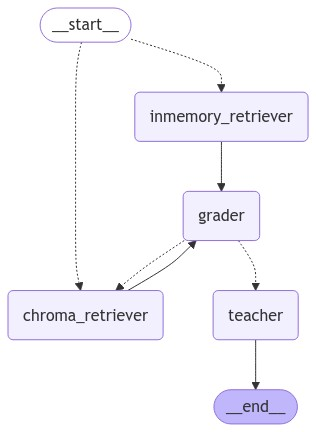

In [13]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

studyagent_workflow = StateGraph(StudyAgentState)

studyagent_workflow.add_node('chroma_retriever', retrieve_docs_chroma)
studyagent_workflow.add_node('inmemory_retriever', retrieve_docs_inmemory)
studyagent_workflow.add_node('grader', grade_docs)
studyagent_workflow.add_node('teacher', answering_teacher)

studyagent_workflow.add_conditional_edges(START, retriever_route, ['inmemory_retriever', 'chroma_retriever'])
studyagent_workflow.add_edge('inmemory_retriever', 'grader')
studyagent_workflow.add_edge('chroma_retriever', 'grader')
studyagent_workflow.add_conditional_edges('grader', got_docs, ['chroma_retriever', 'teacher'])
studyagent_workflow.add_edge('teacher', END)

memory = MemorySaver()
studyagent_graph = studyagent_workflow.compile(checkpointer=persistent_memory)

display(Image(studyagent_graph.get_graph().draw_mermaid_png()))

# Test graph

In [24]:
from langchain_community.document_loaders import TextLoader

uploaded_file = 'data/test_data/Employee handbook.txt'
# uploaded_file = 'langgraph/Sound_detection_blog.pdf'
loader = TextLoader(uploaded_file)
# loader = PyMuPDFLoader(uploaded_file)
session_docs = loader.load() #[]

student_q = 'Hi, Im Alex. What is the company dress code?'
config = {'configurable': {'thread_id': 'Employee2'}}

answer_state = studyagent_graph.invoke({'messages': [HumanMessage(content=student_q)], 'session_docs': session_docs}, config)

--- InMemory Retriever ---
--- Doc Grader ---
--- Teacher ---


In [25]:
from IPython.display import Markdown

Markdown(answer_state['messages'][-1].content)

Hello Alex, according to the Employee Handbook, the dress code of the company requires employees to maintain a strict professional dress code, consisting of baggy clothes in the colors orange and blue. You are expected to dress appropriately for your role and responsibilities.